In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.optimize import minimize
from scipy.stats import norm

In [12]:
# List of tickers
tickers = ['rog', 'cfr', 'zurn']

# Date range for filtering
start_date = '2023-10-25'
end_date = '2024-10-25'

# Function to read and filter CSV files
def read_and_filter_csv(file_path, date_col='Date', price_col='Last Price'):
    df = pd.read_csv(file_path)
    df[date_col] = pd.to_datetime(df[date_col], errors='coerce')
    return df[(df[date_col] >= start_date) & (df[date_col] <= end_date)]

# Initialize the combined DataFrame
combined_df = pd.DataFrame()

# Process tickers for prices and implied volatility
for t in tickers:
    # Read and filter price data
    price_df = read_and_filter_csv(f'../data/{t}.csv')
    price_df = price_df[['Date', 'Last Price']].rename(columns={'Last Price': f'{t.upper()}_Last_Price'})
    
    # Read and filter implied volatility data
    ivol_df = read_and_filter_csv(f'../data/{t}_ivol.csv', price_col='IVOL')
    ivol_column_name = ivol_df.columns[1]
    ivol_df = ivol_df[['Date', ivol_column_name]].rename(columns={ivol_column_name: f'{t.upper()}_IVOL'})

    # Merge the dataframes
    combined_df = pd.merge(combined_df, price_df, on='Date', how='outer') if not combined_df.empty else price_df
    combined_df = pd.merge(combined_df, ivol_df, on='Date', how='outer')

# Read and filter risk-free rate data
risk_free_df = read_and_filter_csv('../data/risk_free.csv')
risk_free_column_name = risk_free_df.columns[1]
risk_free_df = risk_free_df[['Date', risk_free_column_name]].rename(columns={risk_free_column_name: 'Risk_Free_Rate'})

# Merge risk-free rate data
combined_df = pd.merge(combined_df, risk_free_df, on='Date', how='outer')

# Sort and reset index
combined_df = combined_df.sort_values('Date').reset_index(drop=True)

# Show the combined DataFrame
combined_df

,Date,ROG_Last_Price,ROG_IVOL,CFR_Last_Price,CFR_IVOL,ZURN_Last_Price,ZURN_IVOL,Risk_Free_Rate
0,2023-10-25,237.55,17.6858,107.00,33.0793,426.4,15.7900,1.4594
1,2023-10-26,237.25,17.9504,104.45,33.5406,426.8,15.9736,1.4508
2,2023-10-27,237.75,19.6028,104.40,33.4355,424.4,16.3945,1.4478
3,2023-10-30,241.30,19.3503,104.75,33.1531,428.2,15.9477,1.4623
4,2023-10-31,233.85,19.2518,106.90,32.7788,430.6,15.7948,1.4489
...,...,...,...,...,...,...,...,...
248,2024-10-21,272.90,17.7575,126.65,31.1486,526.2,14.1699,0.6532
249,2024-10-22,272.20,18.2963,126.95,30.9890,520.4,14.7228,0.6544
250,2024-10-23,277.20,17.6974,126.05,31.3139,519.6,14.0134,0.6448
251,2024-10-24,279.80,17.7883,128.45,31.6005,520.6,14.4540,0.6213


# Heston Stochastic Volatility Model 

  - **Why**: The Heston model accounts for stochastic volatility, which means it can capture dynamic volatility rather than assuming it’s constant. This better reflects real markets, especially for pricing derivatives or structured products with path-dependent features.
   - **How it works**: It introduces a second stochastic process to model the volatility itself, making it more complex but suitable for capturing market conditions where volatility changes over time.
   - **Output**: Generates more realistic paths that incorporate varying volatility, which can lead to more accurate BRC pricing.

In [13]:
import numpy as np

# Parameters for the Heston model (you may further calibrate based on your data)
kappa = 2.0    # Speed of mean reversion
theta = 0.02   # Long-run variance
sigma = 0.1    # Volatility of volatility
rho = -0.7     # Correlation between price and volatility
v0 = 0.04      # Initial variance

# Simulation parameters
n_paths = 10000  # Number of paths
n_steps = 252    # Number of time steps (daily for one year)
dt = 1 / n_steps # Time increment for daily steps

# Function to simulate Heston model paths
def heston_simulation(s0, v0, T, kappa, theta, sigma, rho, r, n_steps, n_paths):
    dt = T / n_steps
    prices = np.zeros((n_steps + 1, n_paths))
    variances = np.zeros((n_steps + 1, n_paths))
    prices[0] = s0
    variances[0] = v0

    # Generate correlated Brownian motions
    dW1 = np.random.normal(0, np.sqrt(dt), (n_steps, n_paths))
    dW2 = rho * dW1 + np.sqrt(1 - rho ** 2) * np.random.normal(0, np.sqrt(dt), (n_steps, n_paths))

    # Time stepping for price and variance paths
    for t in range(1, n_steps + 1):
        variances[t] = np.maximum(
            variances[t - 1] + kappa * (theta - variances[t - 1]) * dt + sigma * np.sqrt(variances[t - 1]) * dW2[t - 1],
            0
        )
        prices[t] = prices[t - 1] * np.exp(
            (r - 0.5 * variances[t - 1]) * dt + np.sqrt(variances[t - 1]) * dW1[t - 1]
        )

    return prices, variances

# Initialize and simulate for each ticker
tickers = ['ROG', 'CFR', 'ZURN']  # Ensure tickers are as named in the combined DataFrame
T = 1  # Time horizon in years

for t in tickers:
    s0 = combined_df[f"{t}_Last_Price"].iloc[0]  # Initial price from your data
    r = combined_df["Risk_Free_Rate"].iloc[0] / 100  # Convert percentage to decimal if needed

    # Simulate paths using Heston model
    prices, variances = heston_simulation(s0, v0, T, kappa, theta, sigma, rho, r, n_steps, n_paths)

    # Store average simulated path in the DataFrame
    combined_df[f"{t}_Simulated_Price"] = prices.mean(axis=1)

# Display the combined DataFrame with simulated prices
print(combined_df.head())

        Date  ROG_Last_Price  ROG_IVOL  CFR_Last_Price  CFR_IVOL  \
0 2023-10-25          237.55   17.6858          107.00   33.0793   
1 2023-10-26          237.25   17.9504          104.45   33.5406   
2 2023-10-27          237.75   19.6028          104.40   33.4355   
3 2023-10-30          241.30   19.3503          104.75   33.1531   
4 2023-10-31          233.85   19.2518          106.90   32.7788   

   ZURN_Last_Price  ZURN_IVOL  Risk_Free_Rate  ROG_Simulated_Price  \
0            426.4    15.7900          1.4594           237.550000   
1            426.8    15.9736          1.4508           237.566803   
2            424.4    16.3945          1.4478           237.561242   
3            428.2    15.9477          1.4623           237.595355   
4            430.6    15.7948          1.4489           237.621839   

   CFR_Simulated_Price  ZURN_Simulated_Price  
0           107.000000            426.400000  
1           107.007250            426.512536  
2           107.014180       

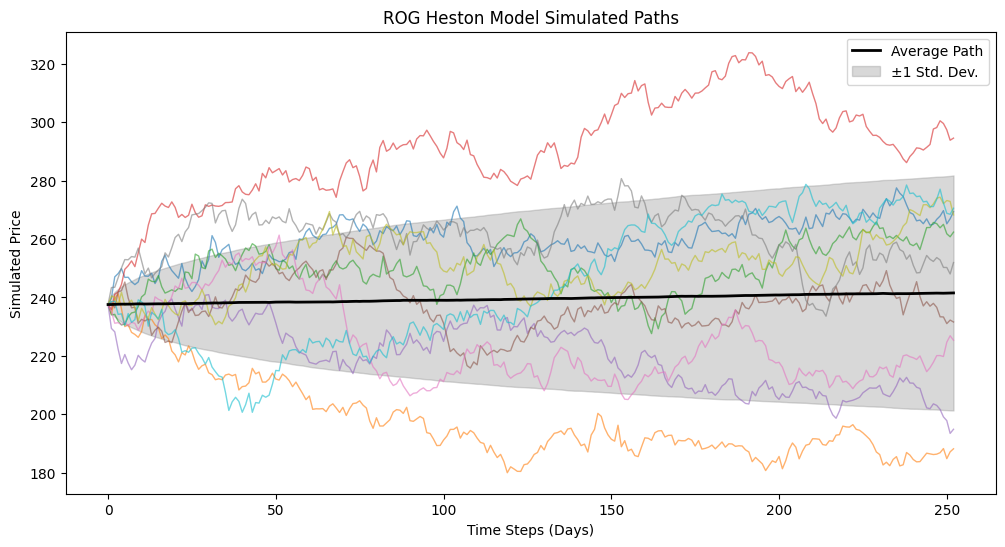

In [15]:
# Choose the ticker for illustration, e.g., "ROG"
ticker = 'ROG'
s0 = combined_df[f"{ticker}_Last_Price"].iloc[0]
r = combined_df["Risk_Free_Rate"].iloc[0] / 100  # Convert to decimal if needed

# Simulate paths using the Heston model
prices, variances = heston_simulation(s0, v0, T, kappa, theta, sigma, rho, r, n_steps, n_paths)

# Plot some individual paths
plt.figure(figsize=(12, 6))
for i in range(10):  # Plot 10 random paths
    plt.plot(prices[:, i], lw=1, alpha=0.6)

# Plot the average path
plt.plot(prices.mean(axis=1), 'k', lw=2, label="Average Path")

# Add confidence interval
plt.fill_between(
    range(n_steps + 1),
    prices.mean(axis=1) - prices.std(axis=1),
    prices.mean(axis=1) + prices.std(axis=1),
    color="gray",
    alpha=0.3,
    label="±1 Std. Dev."
)

plt.title(f"{ticker} Heston Model Simulated Paths")
plt.xlabel("Time Steps (Days)")
plt.ylabel("Simulated Price")
plt.legend()
plt.show()
